# **Regression Analysis for Australia Current Listings**

## Part 1 - Data Acquisition & Rudimentary Analysis

## Part 2 - Regression Analysis

## Part 3 - Conclusion

Author: Mia (Yuhsin Hou)

# Import all libraries

In [0]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as ticker
from scipy import stats
from pylab import rcParams

rcParams['figure.figsize'] = (20, 8)
sns.set_style('darkgrid')
plt.style.use('seaborn-darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

# **Part 1 - Data Acquisition & Rudimentary Analysis**

# **1.1 - Load data**

In [457]:
# Read data from Google Sheet
data_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vR2mwm-Py1jrPOc2rIFUtHI_ck5eW1CFSJbNREzsiCEzS1CmmYORjVr8FJ9SVeEVUP2HQbeNhuMH1mf/pub?gid=1419423504&single=true&output=csv"
housing_data = pd.read_csv(data_path)
housing_data.head(3)

,id,country,state,neighbourhood_cleansed,property_type,square_meters,price,room_type,bathrooms,bedrooms,beds
0,3363954,Australia,NSW,BALLINA SHIRE COUNCIL,House,0.00,"$2,900.00",Entire home/apt,3.0,4.0,4.0
1,13048065,Australia,NSW,BALLINA SHIRE COUNCIL,House,1.55,$28.00,Private room,1.0,1.0,1.0
2,1451202,Australia,NSW,BALLINA SHIRE COUNCIL,Guest suite,15.00,$141.00,Entire home/apt,1.0,1.0,1.0


## Interpret data 

In [458]:
list(housing_data)

['id',
 'country',
 'state',
 'neighbourhood_cleansed',
 'property_type',
 'square_meters',
 'price',
 'room_type',
 'bathrooms',
 'bedrooms',
 'beds']

## Feature difinition 

Here's my interpretation:

*   id: Identification number of each rental data. 
*   country: The country in which the listing resides.
*   state: The state in which the listing resides.
*   neighbourhood_cleansed: A modified version of the neighborhood that can be used for grouping.
*   property_type: The type of property that is being listed (e.g., house, guest suite).
*   square_meters: The rentable square feet amount. (e.g. space you can rent)
*   price: The cost of the rental per night in USD.
*   room_type: The type of room that is available for rent (e.g., a shared room).
*   bathrooms: The count of bathrooms available (e.g., 1, 2, 1.5).
*   bedrooms: The count of bedrooms available (e.g., 0, 1, 2).
*   beds: The count of beds available in the rental (e.g., 0, 1, 2).


*References:*


*   Why some room counts are not whole integers: https://www.ocregister.com/2014/06/01/by-the-numbers-bedroom-and-bathroom-counts-demystified/


# **1.2 - Data preprocessing**

## Drop the columns that are not germane to the analysis

Since 'id' is just the identification numbers of each data entry, I will drop it.  



In [459]:
# Drop 'id' data.
housing_data.drop(['id'], axis =1, inplace = True)

# Get a concise summary of the dataframe. 
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3974 entries, 0 to 3973
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 3974 non-null   object 
 1   state                   3781 non-null   object 
 2   neighbourhood_cleansed  3974 non-null   object 
 3   property_type           3974 non-null   object 
 4   square_meters           3974 non-null   float64
 5   price                   3974 non-null   object 
 6   room_type               3974 non-null   object 
 7   bathrooms               3969 non-null   float64
 8   bedrooms                3972 non-null   float64
 9   beds                    3973 non-null   float64
dtypes: float64(4), object(6)
memory usage: 310.6+ KB


We can see that the column of "id" has been removed. 

However, the data type of “price” should be numeric, so let’s change that.

## Remove dollars signs ($) in price variable

In [0]:
housing_data['price'] = housing_data['price'].str.replace(',', '').str.replace('$', '').astype(float)

# **1.3 - Explore the quantiative variables**

In [461]:
housing_data.describe().round(3)

,square_meters,price,bathrooms,bedrooms,beds
count,3974.000,3974.000,3969.000,3972.000,3973.000
mean,32.523,802.005,1.637,2.263,2.983
std,12.405,885.335,0.832,1.368,1.994
min,0.000,1.000,0.000,0.000,0.000
25%,24.720,200.000,1.000,1.000,1.000
50%,29.695,509.000,1.000,2.000,3.000
75%,35.140,1100.000,2.000,3.000,4.000
max,208.700,11500.000,9.000,12.000,18.000


A few observations:

*   The max price value is 11.5K, so that must be the rental prices, instead of sale prices. 
*   The minimum value of 'price' has 1 dollar, and 0 in 'square_meters', that must be the outliers. 
*   The median price for a rental is 509 dollars, quite below the mean of 802 dollars, indicates it's a positively skewed distribution.


## The distribution of the price variable

Skewness:  2.934
Kurtosis:  16.041


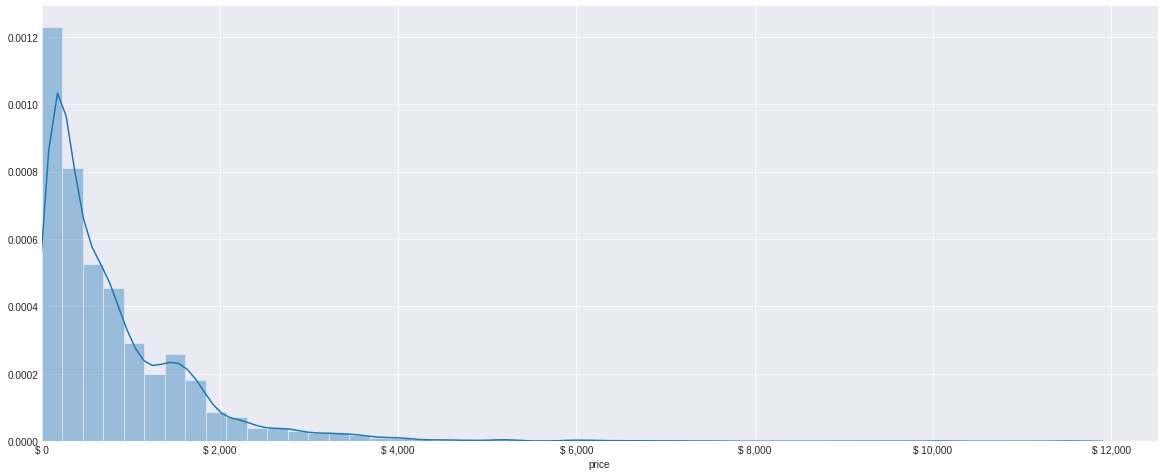

In [462]:
# Visualize the distribution of price dataset.
ax = sns.distplot(housing_data['price'])
plt.xlim(0, None)

# Calculate and print the skewness and kurtosis. 
print('Skewness: ', housing_data['price'].skew().round(3))
print('Kurtosis: ', housing_data['price'].kurt().round(3))

# Set x ticks. 
fmt = '$ {x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)

As I expected, the price variable deviates from the normal distribution.
It shows positive skewness. 

## Remove price outliers

In [463]:
# Trimming off the outliers of the distribution.
starting_percentile = housing_data['price'].quantile(.01)
ending_percentile = housing_data['price'].quantile(.99)

print("Starting percentile: ", starting_percentile)
print("Ending percentile: ", ending_percentile)

Starting percentile:  52.730000000000004
Ending percentile:  4000.27


The outliers are loaded into a dataframe for future analysis.

**A summary of the dataframe contents can be found below.**

In [464]:
houing_data_outliers = housing_data.loc[((housing_data['price'] <= starting_percentile) | (housing_data['price'] >= ending_percentile))]
houing_data_outliers['price'].describe().to_frame()

,price
count,80.000000
mean,2798.962500
std,2981.800889
min,1.000000
25%,45.000000
50%,2026.500000
75%,5158.750000
max,11500.000000


Create a dataframe that has the outliers removed:

In [0]:
housing_data_trimmed = housing_data.loc[((housing_data['price'] > starting_percentile) & (housing_data['price'] < ending_percentile))]

(0.0, 4637.632807021412)

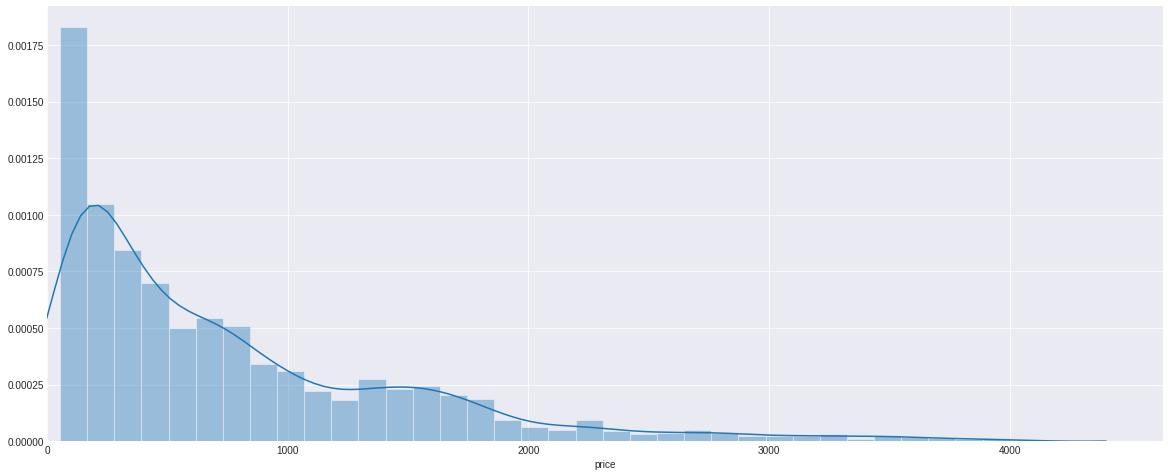

In [466]:
# Replot the distribution. 
ax = sns.distplot(housing_data_trimmed['price'])
plt.xlim(0, None)

The starting price does not from 0, and after trimming the outliers helped make this graph more reasonable.

## Remove square meters outlier

In [467]:
# Trimming off the outliers of the distribution.
starting_percentile = housing_data['square_meters'].quantile(.01)
ending_percentile = housing_data['square_meters'].quantile(.99)

print("Starting percentile: ", starting_percentile)
print("Ending percentile: ", ending_percentile)

# Update a dataframe that has 'square_meters' outliers removed:
housing_data_trimmed = housing_data.loc[((housing_data['square_meters'] > starting_percentile) & (housing_data['square_meters'] < ending_percentile))]

Starting percentile:  12.0
Ending percentile:  66.68270000000001


# **1.4 - Explore the qualitative variables**

In [468]:
housing_data_trimmed[['country', 'state', 'neighbourhood_cleansed', 'property_type', 'room_type']].describe()

,country,state,neighbourhood_cleansed,property_type,room_type
count,3891,3703,3891,3891,3891
unique,1,8,5,8,3
top,Australia,NSW,BYRON SHIRE COUNCIL,House,Entire home/apt
freq,3891,3534,2494,2356,3153


My observations:

*   There is only 1 entry for country, which suggests that we can probably drop that entry.
*   I searched that Australia should only have 6 states, so this is a little bit weird that it has 8 unique entries. We can investigate this more.  
*   There are 5 distinct neighborhoods, but the majority seems to be in Byron Shire Council with 2,494 entries. We can figure it out later.
- There are 8 property types, I feel like it is a little bit much. 


In [469]:
pd.DataFrame(housing_data_trimmed.groupby('state').count()['country'].rename('count')).reset_index()

,state,count
0,NSW,3534
1,New South Wales,113
2,Nsw,4
3,QLD,45
4,Qld,2
5,Queensland,1
6,nsw,3
7,queensland,1


Above are easy to fix. 

Apparently, we can fix above to 2 states: "NSW" and "QLD".

## Collapse 'nsw', 'Nsw', 'New South Wales' to 'NSW' 

In [470]:
housing_data_trimmed_cleaned = housing_data_trimmed.copy()
housing_data_trimmed_cleaned['state'].loc[housing_data_trimmed_cleaned['state'].isin(['nsw', 'Nsw', 'New South Wales'])]='NSW'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## Collapse 'Qld', 'queensland', 'Queensland' to 'QLD'

In [471]:
housing_data_trimmed_cleaned = housing_data_trimmed.copy()
housing_data_trimmed_cleaned['state'].loc[housing_data_trimmed_cleaned['state'].isin(['Qld', 'queensland', 'Queensland'])]='QLD'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## Check with missing value

In [472]:
# Counts all missing values and its percentage.
total = housing_data_trimmed_cleaned.isnull().sum().sort_values(ascending=False)
percent = (housing_data_trimmed_cleaned.isnull().sum() / housing_data_trimmed_cleaned.isnull().count()).sort_values(ascending=False)
frames = [total, percent]
# pd.concat(): axis=0 means index, axis=1 means column, keys = name of the column.
missing_data = pd.concat(frames, axis=1, keys = ['Total', 'Percent'])
missing_data.head()

,Total,Percent
state,188,0.048317
bathrooms,5,0.001285
bedrooms,2,0.000514
beds,1,0.000257
room_type,0,0.000000


Since the variables of 'states', 'bathrooms', 'bedrooms', and 'beds' are not seem so important in my future analysis, I will ignore them.

## Review the neighbourhood_cleansed variable

In [473]:
housing_data_trimmed_cleaned_nbhood_agg_full = pd.DataFrame(housing_data_trimmed_cleaned.groupby('neighbourhood_cleansed').count()['property_type'].rename('count')).reset_index().sort_values(by=['count'], ascending = False)
housing_data_trimmed_cleaned_nbhood_agg = housing_data_trimmed_cleaned_nbhood_agg_full.copy().head(45)
housing_data_trimmed_cleaned_nbhood_agg['percentage'] = housing_data_trimmed_cleaned_nbhood_agg['count'].cumsum() / housing_data_trimmed_cleaned_nbhood_agg['count'].sum()*100

print('\nTop 5 records: \n')
pd.concat([housing_data_trimmed_cleaned_nbhood_agg.head(5)])


Top 5 records: 



,neighbourhood_cleansed,count,percentage
1,BYRON SHIRE COUNCIL,2494,64.096633
4,TWEED SHIRE COUNCIL,853,86.019018
0,BALLINA SHIRE COUNCIL,443,97.404266
2,LISMORE CITY COUNCIL,85,99.588795
3,RICHMOND VALLEY COUNCIL,16,100.000000


I will create a graph below makes it clear that the distribution of the listings is wide.

## Plot the 'neighbourhood_cleansed' using a bar and pareto chart 

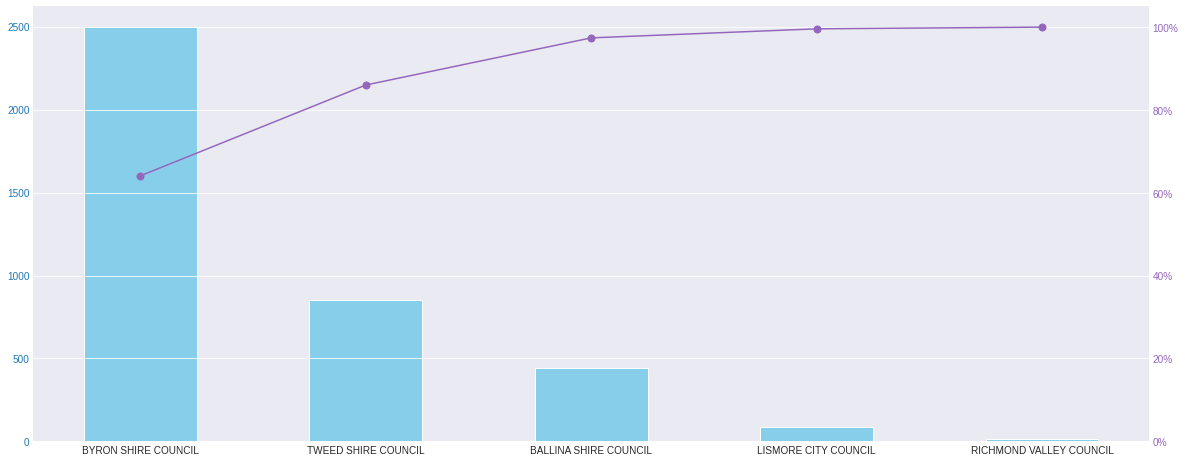

In [474]:
fig, ax = plt.subplots()
ax.bar(housing_data_trimmed_cleaned_nbhood_agg['neighbourhood_cleansed'], housing_data_trimmed_cleaned_nbhood_agg['count'], color = 'skyblue', width = 0.5)

ax2 = ax.twinx()
ax2.plot(housing_data_trimmed_cleaned_nbhood_agg['neighbourhood_cleansed'], housing_data_trimmed_cleaned_nbhood_agg['percentage'], color='C4', marker='o', ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.grid(None)
ax.tick_params(axis='y', colors='C10')
ax2.tick_params(axis='y', colors='C4')
ax2.set_ylim((0,105))
ax.set_xticklabels(housing_data_trimmed_cleaned_nbhood_agg['neighbourhood_cleansed'], rotation=0, ha='center')
plt.show()

## Explore the property_type variable

In [475]:
housing_data_trimmed_cleaned_prop_type_agg = pd.DataFrame(housing_data_trimmed_cleaned.groupby('property_type').count()['neighbourhood_cleansed'].rename('count')).reset_index().sort_values(by=['count'], ascending = False)
housing_data_trimmed_cleaned_prop_type_agg['percentage'] = housing_data_trimmed_cleaned_prop_type_agg['count'].cumsum() / housing_data_trimmed_cleaned_prop_type_agg['count'].sum()*100
housing_data_trimmed_cleaned_prop_type_agg.head(10)

,property_type,count,percentage
4,House,2356,60.549987
0,Apartment,958,85.170907
2,Guest suite,257,91.775893
3,Guesthouse,216,97.327165
1,Camper/RV,41,98.380879
5,Loft,23,98.971987
6,Nature lodge,21,99.511694
7,Other,19,100.000000


## Plot the 'property_type' using a bar and pareto chart

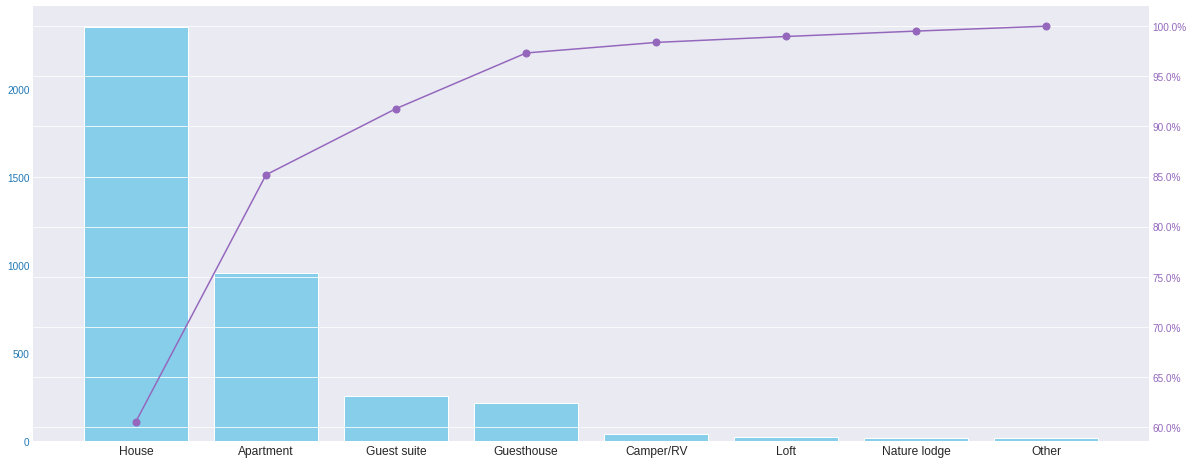

In [476]:
fig, ax = plt.subplots()
ax.bar(housing_data_trimmed_cleaned_prop_type_agg['property_type'], housing_data_trimmed_cleaned_prop_type_agg['count'], color = 'skyblue')

ax2 = ax.twinx()
ax2.plot(housing_data_trimmed_cleaned_prop_type_agg['property_type'], housing_data_trimmed_cleaned_prop_type_agg['percentage'], color='C4', marker='o', ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.grid(None)
ax.tick_params(axis='y', colors='C10')
ax2.tick_params(axis='y', colors='C4')

ax.set_xticklabels(housing_data_trimmed_cleaned_prop_type_agg['property_type'], rotation=0, ha='center', fontsize = 12)
plt.show()

## Explore the room_type variable

In [477]:
housing_data_trimmed_cleaned_room_type_agg = pd.DataFrame(housing_data_trimmed_cleaned.groupby('room_type').count()['neighbourhood_cleansed'].rename('count')).reset_index().sort_values(by=['count'], ascending = False)
housing_data_trimmed_cleaned_room_type_agg['percentage'] = housing_data_trimmed_cleaned_room_type_agg['count'].cumsum() / housing_data_trimmed_cleaned_room_type_agg['count'].sum()*100
housing_data_trimmed_cleaned_room_type_agg.head()

,room_type,count,percentage
0,Entire home/apt,3153,81.033153
1,Private room,735,99.922899
2,Shared room,3,100.000000


## Plot the room_type using a bar and pareto chart 

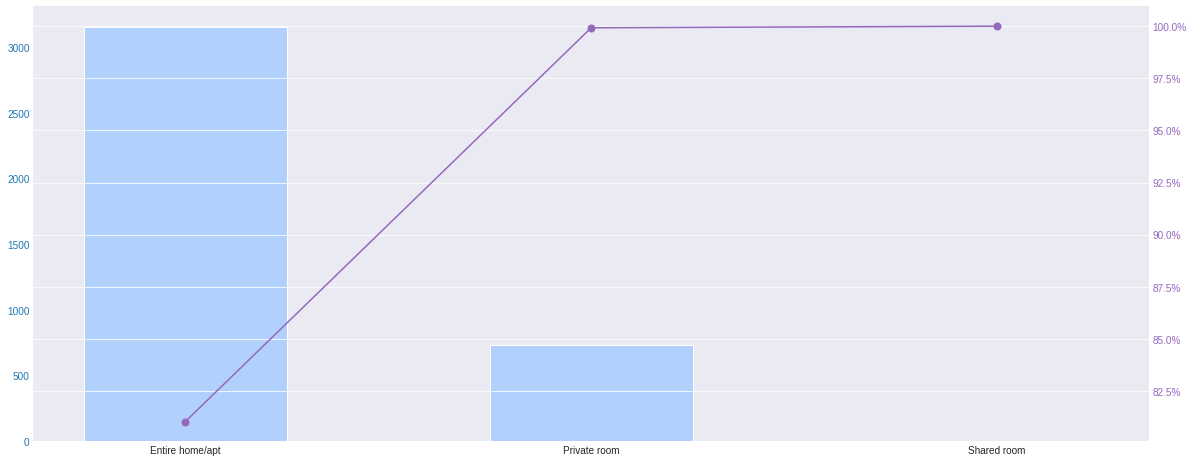

In [478]:
fig, ax = plt.subplots()
ax.bar(housing_data_trimmed_cleaned_room_type_agg['room_type'], housing_data_trimmed_cleaned_room_type_agg['count'], color='#b1d1fc', width = 0.5, data = 'y')

ax2 = ax.twinx()
ax2.plot(housing_data_trimmed_cleaned_room_type_agg['room_type'], housing_data_trimmed_cleaned_room_type_agg['percentage'], color='C4', marker='o', ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.grid(None)
ax.tick_params(axis='y', colors='C10')
ax2.tick_params(axis='y', colors='C4')

ax.set_xticklabels(housing_data_trimmed_cleaned_room_type_agg['room_type'], rotation=0, ha='center')
plt.show()

 # **1.5 - Second order analysis: filter data and analyze price distributions per select categorical variables**

To simpllify the problem space, I dropped some categories from specific variables. 

Mainly focused on top 3 features. 

*   neighbourhood_cleansed: 'BALLINA SHIRE COUNCIL', 'TWEED SHIRE COUNCIL', and 'BYRON SHIRE COUNCIL'
*   property_type: 'Apartment', 'House', and 'Guest suite'
*   room_type: 'Entire home/apt'
*   price: all


In [479]:
housing_data_top3_nbhood_filtered = housing_data_trimmed.loc[(housing_data_trimmed['neighbourhood_cleansed'].isin(['BALLINA SHIRE COUNCIL', 'TWEED SHIRE COUNCIL', 'BYRON SHIRE COUNCIL']))]
housing_data_top3_nbhood_filtered = housing_data_top3_nbhood_filtered.loc[(housing_data_top3_nbhood_filtered['property_type'].isin(['Apartment', 'House', 'Guest suite']))]
housing_data_top3_nbhood_filtered = housing_data_top3_nbhood_filtered.loc[(housing_data_top3_nbhood_filtered['room_type'] == 'Entire home/apt')]
housing_data_top3_nbhood_filtered[['neighbourhood_cleansed', 'property_type', 'room_type']].describe()

,neighbourhood_cleansed,property_type,room_type
count,2829,2829,2829
unique,3,3,1
top,BYRON SHIRE COUNCIL,House,Entire home/apt
freq,1818,1741,2829


[None, None]

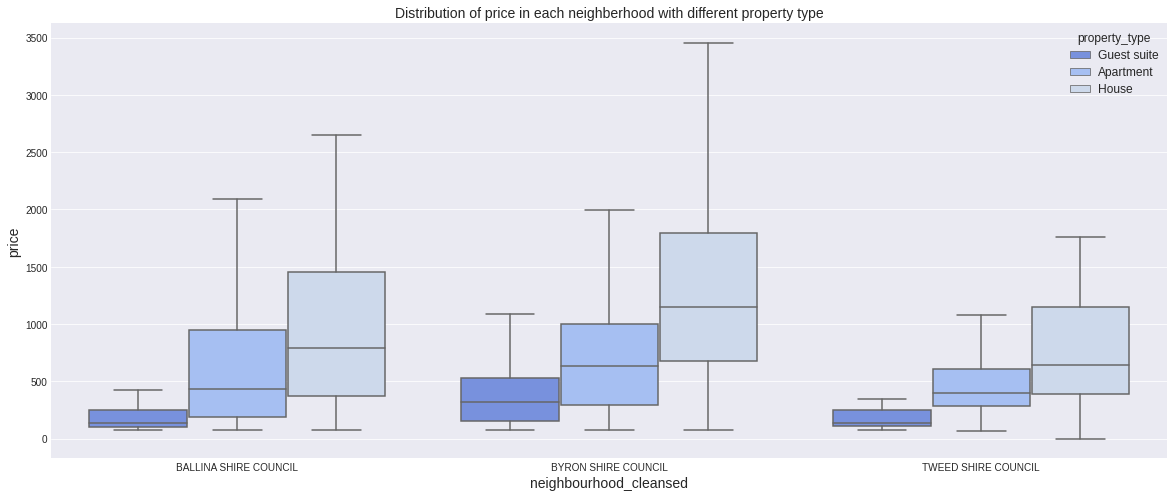

In [480]:
# Create a boxplot.
ax = sns.boxplot(y='price', x = 'neighbourhood_cleansed', hue='property_type', data = housing_data_top3_nbhood_filtered, showfliers = False, palette = sns.color_palette('coolwarm'))

# Set x and y lable name and the title of this scatterplot.
ax.set_xlabel('neighbourhood_cleansed', fontsize = 14)
ax.set_ylabel('price', fontsize = 14)
ax.set_title('Distribution of price in each neighberhood with different property type', fontsize = 14)

# Set font size for legend text and title.
plt.setp(ax.get_legend().get_texts(), fontsize='12') 
plt.setp(ax.get_legend().get_title(), fontsize='12')

# **Part 1 Summary of findings**

*   Through the EDA, I interpreted the meaning of each variable, in order to analyze their importances. 
*   For the univariable study, I focused on the dependent variable: "price". While I found that there are a few outliers, after making the distribution plot. Price below 52 USD and greater than 4,000 USD are unusual. Considering they may distort statistical analyses and violate the assumptions later, I removed the outliers. Since I have learned from the class that consequently, excluding outliers can cause my results to become statistically significant.
*   Similarly, there are a few outliers in the "square_meters" variable as well. So I removed the square meters below 12 and above 68.2 values. 
*   For data preprocessing, there are several features that we do not need. Such as "id" and “country” (there's only 1 entry for the country: Australia). We have "neighbourhood_cleansed" and "state" as a location variable.
*   There were a few data anomalies that required to clean and normalization. (e.g., I merged 'nsw', 'Nsw', 'New South Wales' to 'NSW'). 
*   Overall, based on this dataset, Australia can cluster the neighborhood into 3 rent groups: 1. The most expensive rent price were in Byron Shire Council area, across any property type variables. 2. Average rent prices in Australua were in Ballina Shire Council. 3. Low rent prices were in Tweed Shire Council.
*   In addition, high-end pricing in Byron Shire Council is substantially higher, and is the most popular neighborhood (with 2,447 frequency) as compared to other areas as well. 
*   If I were to rent a property, I might want to rent for an apartment in Byron Shire Council, taget in a median price range from 500 USD to 1,000 USD. Because it has the higher rent prices, I assume the area must have some advantages. For example, good location, safe and secure neighborhood, or other factors that make the rent price higher. 
















# **Part 2 - Linear Regression**

# **2.1 - Describe regression approach**

Initially, I want to verify whether "square meters" is correlated with "price". I will plot the results.

**yˆ = θ0+θ1x1+θ2x2+⋯+θnxn**

First, check the overrall data distribution. 

(2829, 10)

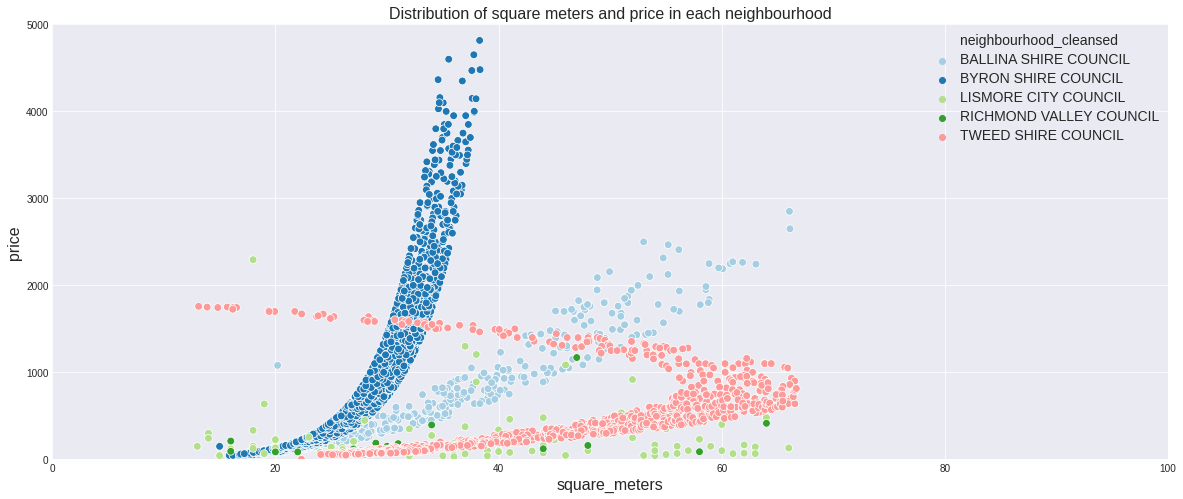

In [481]:
# Set the plot size.
rcParams['figure.figsize'] = (20, 8)

# Create a scatterplot. 
ax = sns.scatterplot(x = 'square_meters', y = 'price', data = housing_data_trimmed_cleaned, hue = 'neighbourhood_cleansed', s = 60, palette = sns.color_palette('Paired', n_colors = 5))

# Set x and y lable name and the title of this scatterplot.
ax.set_xlabel('square_meters', fontsize = 16)
ax.set_ylabel('price', fontsize = 16)
ax.set_title('Distribution of square meters and price in each neighbourhood', fontsize = 16)

# Set the range of x and y axis. 
plt.xlim([0, 100])
plt.ylim([0, 5000])

# Set font size for legend text and title.
plt.setp(ax.get_legend().get_texts(), fontsize='14') 
plt.setp(ax.get_legend().get_title(), fontsize='14')

# Check the shape of data again.
housing_data_top3_nbhood_filtered.shape

We can see that Lismore City Council and Richmond Valley Council do not have much dataset, and they are clearly do not have linear relationship between price and square meters. Thus. I will exclude these 2 areas when analyzing regression.  

## Focus on 3 neighbourhoods

Create the scatter plot with filtered 3 neighbourhoods. 

(2829, 10)

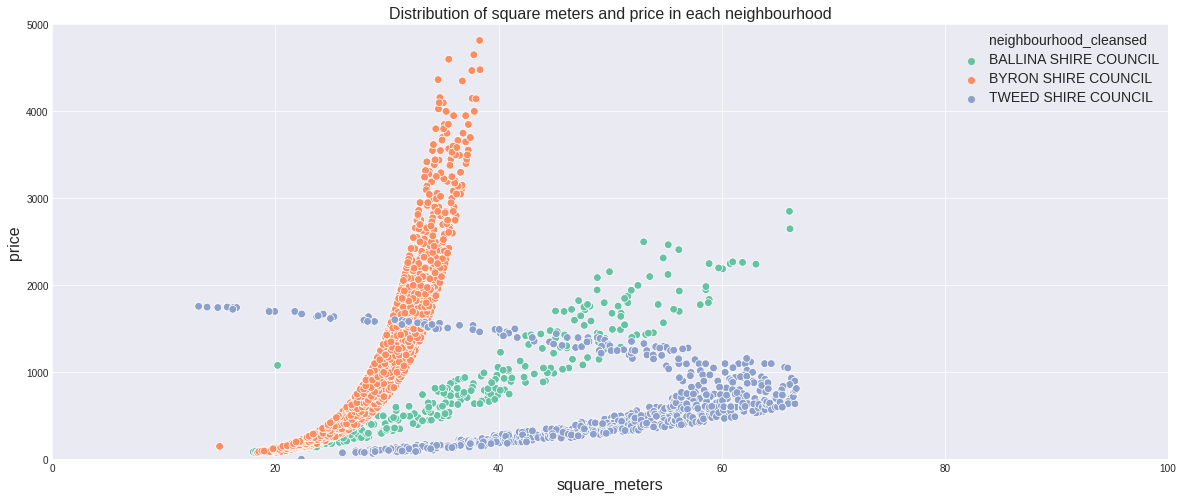

In [482]:
# Set the plot size.
rcParams['figure.figsize'] = (20, 8)

# Create a scatterplot. 
ax = sns.scatterplot(x = 'square_meters', y = 'price', data = housing_data_top3_nbhood_filtered, hue = 'neighbourhood_cleansed', s = 60, palette = sns.color_palette('Set2', n_colors = 3))

# Set x and y lable name and the title of this scatterplot.
ax.set_xlabel('square_meters', fontsize = 16)
ax.set_ylabel('price', fontsize = 16)
ax.set_title('Distribution of square meters and price in each neighbourhood', fontsize = 16)

# Set the range of x and y axis. 
plt.xlim([0, 100])
plt.ylim([0, 5000])

# Set font size for legend text and title.
plt.setp(ax.get_legend().get_texts(), fontsize='14') 
plt.setp(ax.get_legend().get_title(), fontsize='14')

# Check the shape of data again.
housing_data_top3_nbhood_filtered.shape

It's interesting that the rent price clusters the neighborhood into 3 distributions. 

However, both Tweed Shire Council and Ballina Shire Council are obviously not fit the regression line. 

Thus, I will spliting into below 3 groups to build linear regression model, and see each model performance. 

*   Byron Shire Council
*   Ballina Shire Council
*   Tweed Shire Council


# **2.2 Linear Regression Model in Byron Shire Council** 

Since the relationship between square meters and price in Byron Shire Council is clearly a exponential distribution, I will first apply the log transformation to make the later linear regression model performs better. 

In [483]:
# Apply log transformation.
housing_data_top3_nbhood_filtered['log_price'] = np.log(housing_data_top3_nbhood_filtered['price'])
housing_data_top3_nbhood_filtered.shape
housing_data_top3_nbhood_filtered.describe().round(3)

,square_meters,price,bathrooms,bedrooms,beds,log_price
count,2829.000,2829.000,2828.000,2828.000,2828.000,2829.000
mean,34.563,988.065,1.820,2.660,3.516,6.513
std,11.214,919.003,0.849,1.318,1.957,0.922
min,13.120,1.000,0.000,0.000,0.000,0.000
25%,27.600,350.000,1.000,2.000,2.000,5.858
50%,31.150,732.000,2.000,3.000,3.000,6.596
75%,37.540,1399.000,2.000,4.000,5.000,7.244
max,66.680,11500.000,9.000,12.000,18.000,9.350


In [0]:
# Filter the specific areas to build linear regression model.
housing_data_BYRON_filtered = housing_data_top3_nbhood_filtered.loc[(housing_data_top3_nbhood_filtered['neighbourhood_cleansed'].isin(['BYRON SHIRE COUNCIL']))]

# Set X and y.
X = housing_data_BYRON_filtered['square_meters']
y = housing_data_BYRON_filtered['log_price']

# Reshape and load remaining data sets.
X = X.values.reshape(-1, 1)
y = housing_data_BYRON_filtered['log_price'].values.reshape(-1, 1)

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Create the linear regression object and train/fit models.
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Make predictions using the testing set.
listing_y_pred = regressor.predict(X_test)

## Caculate below information to verify the model's performance  

*   y_prediction
*   Intercept
*   Mean Squared Error (MSE)
*   R squared (R^2)



In [485]:
# Print a few predictions
print((pd.DataFrame(listing_y_pred, columns={'y_prediction'}).head(5)))
print()

# Print the intercept
print('Intercept:', float(regressor.intercept_))

# Print the coefficient(s)
coeff_df = pd.DataFrame(regressor.coef_)
coeff_df.columns = ['square_meters']
print(coeff_df)
print()

# Performance Metric: Mean Squared Error
print("Mean Squared Error (MSE):  %.2f" % mean_squared_error(y_test, listing_y_pred))

# Explained variance score:
print('R Squared (R^2):  %.2f' % r2_score(y_test, listing_y_pred))

   y_prediction
0      6.119065
1      6.651898
2      7.308696
3      6.488786
4      7.197780

Intercept: 0.37317093414685676
   square_meters
0       0.217483

Mean Squared Error (MSE):  0.04
R Squared (R^2):  0.95


## Graphical representation from Scikit-Learn result 

(1818, 11)

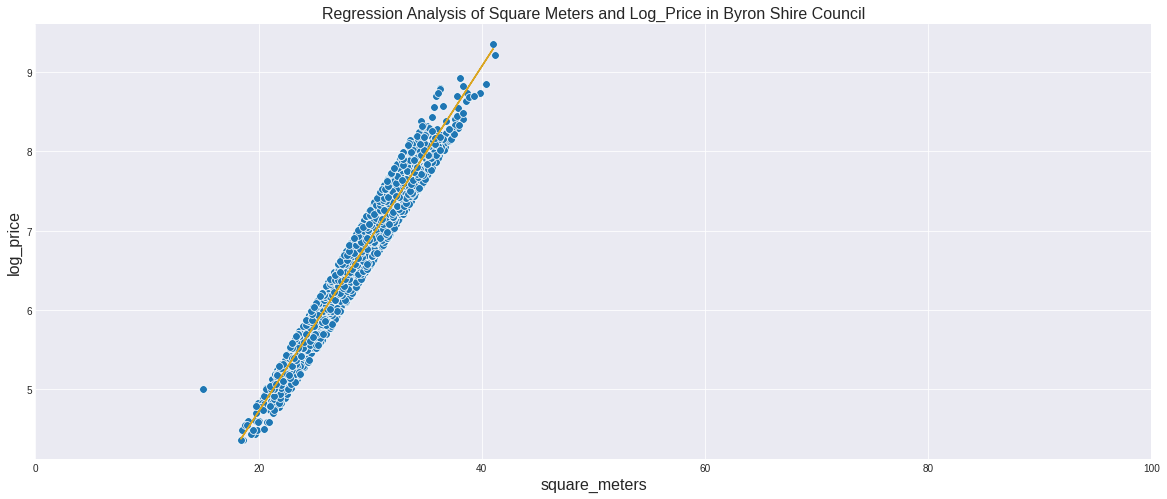

In [486]:
# Create a scatterplot. 
ax = sns.scatterplot(x = 'square_meters', y = 'log_price', data = housing_data_BYRON_filtered, s=60)
plt.plot(X_test, listing_y_pred, color='goldenrod')

ax.set_xlabel('square_meters', fontsize = 16)
ax.set_ylabel('log_price', fontsize = 16)
ax.set_title('Regression Analysis of Square Meters and Log_Price in Byron Shire Council', fontsize = 16)

plt.xlim([0, 100])

housing_data_BYRON_filtered.shape

**After log transformation, we can see that the R squared value is 0.95** 

(means 95% of the variability in y - price can be explained by using X - square meters), 

and above scatter plot shows a positive linear relationship between square 
meters and price in Byron Shire Council as well.

Thus, I consider this model performs well, and can be used to predict price.

# **2.3 Linear Regression Model of Ballina Shire Council**

In [0]:
# Filter the specific areas to build linear regression model.
housing_data_BALLINA_filtered = housing_data_top3_nbhood_filtered.loc[(housing_data_top3_nbhood_filtered['neighbourhood_cleansed'].isin(['BALLINA SHIRE COUNCIL']))]

# Set X and y. 
X2 = housing_data_BALLINA_filtered['square_meters']
y2 = housing_data_BALLINA_filtered['price']

# Reshape and load remaining data sets
X2 = X2.values.reshape(-1, 1)
y2 = housing_data_BALLINA_filtered['price'].values.reshape(-1, 1)

# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2)

# Create the linear regression object and train/fit models
regressor2 = LinearRegression()
regressor2.fit(X_train2, y_train2)

# Make predictions using the testing set
listing_y_pred2 = regressor2.predict(X_test2)

## Caculate below information to verify the model's performance

*   y_prediction
*   Intercept
*   Mean Squared Error (MSE)
*   R squared (R^2)



In [488]:
# Print a few predictions
print((pd.DataFrame(listing_y_pred2, columns={'y_prediction'}).head(5)))
print()

# Print the intercept
print('Intercept:', float(regressor2.intercept_))

# Print the coefficient(s)
coeff_df2 = pd.DataFrame(regressor2.coef_)
coeff_df2.columns = ['square_meters']
print(coeff_df2)
print()

# Performance Metric: Mean Squared Error
print("Mean Squared Error (MSE):  %.2f" % mean_squared_error(y_test2, listing_y_pred2))

# Explained variance score:
print('R Squared (R^2):  %.2f' % r2_score(y_test2, listing_y_pred2))

   y_prediction
0    600.883716
1   1229.543866
2     15.669688
3    898.201756
4   1437.875873

Intercept: -1073.100597143507
   square_meters
0      52.344725

Mean Squared Error (MSE):  35036.49
R Squared (R^2):  0.90


## Graphical representation from Scikit-Learn result 

(340, 11)

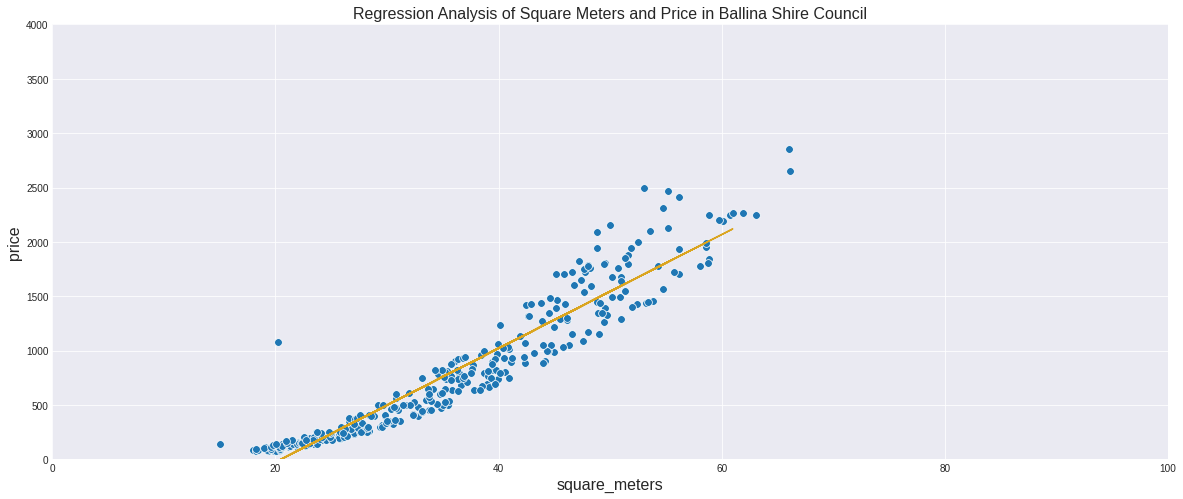

In [489]:
ax = sns.scatterplot(x = 'square_meters', y = 'price', data = housing_data_BALLINA_filtered, s=60)
plt.plot(X_test2, listing_y_pred2, color='goldenrod')

ax.set_xlabel('square_meters', fontsize = 16)
ax.set_ylabel('price', fontsize = 16)
ax.set_title('Regression Analysis of Square Meters and Price in Ballina Shire Council', fontsize = 16)
plt.xlim([0, 100])
plt.ylim([0, 4000])

housing_data_BALLINA_filtered.shape

**We can see that the R squared value is 0.90**

(means 90% of the variability in y - price can be explained by using X - square meters), 

and above scatter plot shows a positive linear relationship between square meters and price in Ballina Shire Council as well. 

# **2.4 Cannot explain Linear Regression Model in Tweed Shire Council**

In [0]:
# Filter the specific areas to build linear regression model.
housing_data_TWEED_filtered = housing_data_top3_nbhood_filtered.loc[(housing_data_top3_nbhood_filtered['neighbourhood_cleansed'].isin(['TWEED SHIRE COUNCIL']))]

# Set X and y. 
X3 = housing_data_TWEED_filtered['square_meters']
y3 = housing_data_TWEED_filtered['price']

# Reshape and load remaining data sets
X3 = X3.values.reshape(-1, 1)
y3 = housing_data_TWEED_filtered['price'].values.reshape(-1, 1)

# Split the data into training and testing sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3)

# Create the linear regression object and train/fit models
regressor3 = LinearRegression()
regressor3.fit(X_train3, y_train3)

# Make predictions using the testing set
listing_y_pred3 = regressor3.predict(X_test3)

## Caculate below information to verify the model's performance


*   y_prediction
*   Intercept
*   Mean Squared Error (MSE)
*   R squared (R^2)


In [491]:
# Print a few predictions
print((pd.DataFrame(listing_y_pred3, columns={'y_prediction'}).head(5)))
print()

# Print the intercept
print('Intercept:', float(regressor3.intercept_))

# Print the coefficient(s)
coeff_df3 = pd.DataFrame(regressor3.coef_)
coeff_df3.columns = ['square_meters']
print(coeff_df3)
print()

# Performance Metric: Mean Squared Error
print("Mean Squared Error (MSE):  %.2f" % mean_squared_error(y_test3, listing_y_pred3))

# Explained variance score:
print('R Squared (R^2):  %.2f' % r2_score(y_test3, listing_y_pred3))

   y_prediction
0    578.507245
1    648.011347
2    629.884960
3    612.199962
4    589.630255

Intercept: 477.07598320973193
   square_meters
0       2.942595

Mean Squared Error (MSE):  161564.64
R Squared (R^2):  -0.02


## Graphical representation from Scikit-Learn result

(0.0, 100.0)

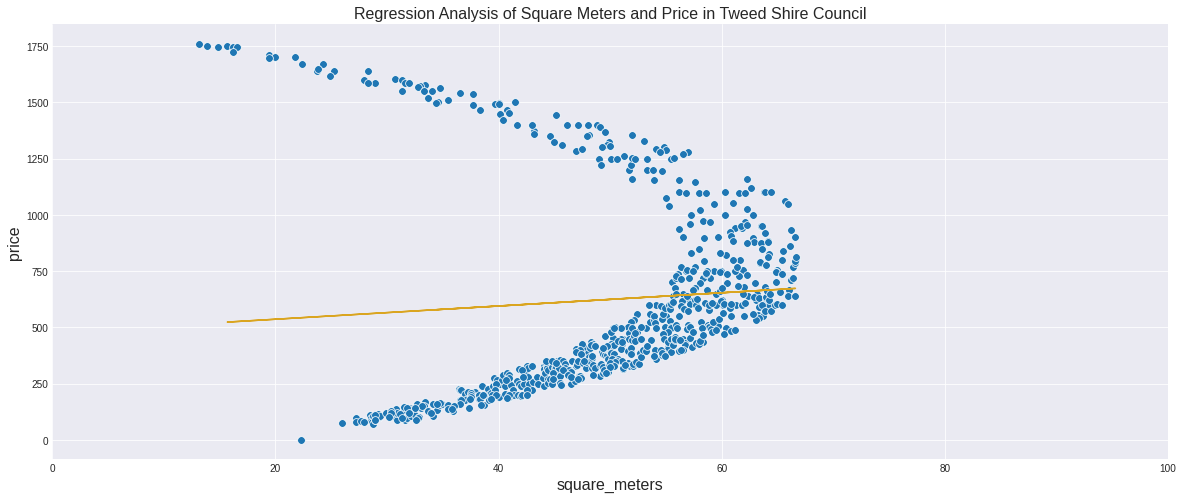

In [492]:
# Make a scatter plot.
ax = sns.scatterplot(x = 'square_meters', y = 'price', data = housing_data_TWEED_filtered, s=60)
plt.plot(X_test3, listing_y_pred3, color='goldenrod')

# Set x axis and y axis name, and plot title. 
ax.set_xlabel('square_meters', fontsize = 16)
ax.set_ylabel('price', fontsize = 16)
ax.set_title('Regression Analysis of Square Meters and Price in Tweed Shire Council', fontsize = 16)

# Set the limit number of x axis. 
plt.xlim([0, 100])

**Obviously, there's no linear relationship between square meters and price in Tweed Shire Council.**

**That cannot use Linear Regression Model. I will try the Random Forest and Gradient Boosting ones to see which model performs best.**

# **2.5 Random Forest** 

In [493]:
forest_reg = RandomForestRegressor(random_state = 20)
forest_reg.fit(X_train, y_train)

print('Random Forest R squared: %.4f' % forest_reg.score(X_test, y_test))

Random Forest R squared: 0.9338


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [494]:
y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_pred, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

Random Forest RMSE: 0.2389


R squared increased from -0.01 to 0.93. Much better! I'll try one more.

# **2.6 Gradient Boosting**

In [495]:
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [496]:
print('Gradient Boosting R squared: %.4f' % model.score(X_test, y_test))

Gradient Boosting R squared: 0.9491


In [497]:
y_pred = model.predict(X_test)
model_mse = mean_squared_error(y_pred, y_test)
model_rmse = np.sqrt(model_mse)
print('Gradient Boosting RMSE: %.4f' % model_rmse)

Gradient Boosting RMSE: 0.2094


These are the best results I have so far, so, I would consider this is my final model. 

**However, do these results make sense?** 

**No, these do not make sense.**

**Since Tweed Shire Council contains some anomalous data:**

- The price below 750 USD seems have a positive linear relationship with square meters. The more square meters you want, costs you more rent price.
- However, the price above 750 USD seems have a negative linear relationship with square meters. It does not make sense that the more square meters you have, costs you less rent price.

Thus, I will draw some of my assumptions in below below conclusion. 

# **Part 3 - Conclusion**

## **Based on above regression analysis filtered in 3 neighbourhood areas, Byron Shire Council is an area that I would like to provide the pricing recommendations.**

According to my analysis, Byron Shire Council has the the best variability in price can be explained using square meters. 

Byron Shire Council has the highest R squared value (0.95) and largest dataset (1,818 entries), that makes it the best performing model among all neighbourhoods.

**Note that the price prediction is after applying the log transformation, with focused on below features.**

- Property type: apartment, house, and guest suite. 
- Room type: entire home / apt.

## **Below are my assertions / claims:**

## Q1.  Why not Tweed Shire Council?

*   Linear Regression Model (R^2: near 0.01) and scatter plot representation from Scikit-Learn result indicate **there's no linear relationship between square meters and price.** 

*   However, the reasons why my R-squared can be increased to 0.93 and 0.94 respectively in Random Forest and Gradient Boosting Model, might because of **overfitting dataset issue, and lack of training data.**

*   Regardless of which Machine Learning model I use, does not matter to the prediction performance. I cannot predict the price in Tweed Shire Council is because I don’t actually have data that represents a predictable pattern. **There might have some other features affected the price, such as year built, overrall quality, amenities, etc. But they are not included in this dataset, makes prediction difficultly.**

- Some of my conjectures why the distribution in Tweed Shire Council is unusual: 

 1. Data entry errors (human errors) in original dataset.
 2. Probably Tweed Shire Council has very remoted suburban or rural areas, so that the square meters is significantly big, while the rent price is ridiculously low.

*   To improve above problems, I suggest to collect additional features (variables) to determine which factors influence the price most. 


## Q2. Why Byron Shire Council, instead of Ballina Shire Council?

*   Although there are not so much difference on model performance between Byron Shire Council and Ballina Shire Council (R^2: 0.95 v.s. 0.90). Considering the amount of data, Ballina Shire Council only have 340 entries of data, while Byron have 1,818 entries of data. There's one concern that the small data might cause the model overfitting. 
- To remove above concern, I suggest to feed larger data when building a linear regression model.  

## Q3. Why not Lismore City Council and Richmond Valley Council?

- According to part 1.4 (review the neighbourhood_cleansed variable), we can see that Lismore City Council and Richmond Valley Council do not have much data, with only 85 and 16 entries respectively. In addition, the scatter plot suggesting they don't have linear relationship between price and square meters. Thus, I excluded them. 

*References*

- Breaking the curse of small datasets in Machine Learning: Part 1 

https://towardsdatascience.com/breaking-the-curse-of-small-datasets-in-machine-learning-part-1-36f28b0c044d


